### Importing the necessary dependencies:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.utils import resample
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
import statistics
from statistics import mode

### Importing the data files:

In [123]:
#statistical analysis on features:
df=pd.read_csv('/home/vboxuser/VoiceFiles/Voice4PD-MSA-Tool-global_V2/ProsodyData/stat_pr/prosodyfeaturesst_seg_train_stat.csv')
#train and test data:
df_train=pd.read_csv('/home/vboxuser/VoiceFiles/Voice4PD-MSA-Tool-global_V2/ProsodyData/prosodyfeaturesst_seg_dev.csv')
df_test=pd.read_csv('/home/vboxuser/VoiceFiles/Voice4PD-MSA-Tool-global_V2/ProsodyData/prosodyfeaturesst_seg_test.csv')

In [4]:
prosody_test=pd.read_csv('/home/vboxuser/VoiceFiles/Prosodyfeaturesst_test.csv')

## Building a model with feature selection:

### Preprocessing the data:

#### 1. Extract the features that are a good discriminant:

In [5]:
df.head()

,Unnamed: 0,p_HC_DP,p_HC_DP.1
0,F0avg,0.412638,0.022083
1,F0std,0.081670,-0.051671
2,F0max,0.003043,-0.057737
3,F0min,0.546466,0.004791
4,F0skew,0.000001,-0.091609


In [6]:
#from the {ImageFolder..} file obtained earlier from feature_analysis we take those values that have p_val<0.05 and effect_size>|0.4|
req_features=df[(df['p_HC_DP']<0.05) | (abs(df['p_HC_DP.1'])>0.4)]

#### 2. Obtain the selected good features as a list:

In [7]:
feature_list=req_features['Unnamed: 0'].tolist()
print(len(feature_list))

20


#### 3. Obtaining X_train & Y_train:

In [8]:
df_train

,subject,F0avg,F0std,F0max,F0min,F0skew,F0kurt,F0tiltavg,F0mseavg,F0tiltstd,...,kurtosisdurpause,maxdurpause,mindurpause,PVU,PU,UVU,VVU,VP,UP,Group
0,300_P_0.wav,165.908508,38.275139,257.928467,94.493355,0.426894,-0.647107,-65.049128,324.063212,126.268062,...,-0.866593,0.340000,0.149977,0.525115,4.608241,0.113951,0.886049,1.687344,0.217003,HC
1,300_P_1.wav,120.528053,12.529911,146.793304,86.951614,-0.113077,-0.996979,-20.992859,13.360108,24.507299,...,-1.594899,0.600000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,HC
2,300_P_10.wav,133.895416,21.495996,205.637115,98.742012,2.033316,3.646668,-149.393324,33.461422,185.119105,...,-0.758323,0.560000,0.320000,0.693961,3.659039,0.189657,0.810343,1.167707,0.273296,HC
3,300_P_11.wav,144.578720,28.399199,238.035019,100.053619,1.236097,0.991367,-15.509460,188.202717,25.538555,...,-2.000000,0.300000,0.190023,0.439975,3.827760,0.114943,0.885057,2.011608,0.261249,HC
4,300_P_12.wav,141.704803,28.684387,214.766144,108.876251,1.277414,0.580108,-18.155109,74.524664,111.242072,...,-1.487127,0.540000,0.150023,0.767724,4.291161,0.178908,0.821092,1.069515,0.233037,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,713_P_5.wav,121.557548,36.611835,259.327454,66.125931,1.220141,1.760276,-8.349025,184.875451,123.734211,...,-0.474507,0.549977,0.160000,1.011893,6.071267,0.166669,0.833331,0.823537,0.164710,HC
5019,713_P_6.wav,98.142693,11.498760,151.283951,70.990318,1.337210,3.094978,-107.072079,36.489500,95.307558,...,-1.283715,0.989977,0.289977,1.545837,5.899887,0.262011,0.737989,0.477404,0.169495,HC
5020,713_P_7.wav,112.744049,50.676796,264.040283,67.474419,2.159553,3.558457,-55.952834,24.763987,92.611292,...,0.848076,1.200000,0.169977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,HC
5021,713_P_8.wav,114.727715,21.992062,206.498825,74.076416,1.794884,4.758493,11.662198,51.707118,276.472244,...,-1.088540,0.520000,0.269977,1.363187,5.240970,0.260102,0.739898,0.542771,0.190804,HC


In [88]:
df_train.shape

(5023, 105)

In [9]:
df_train=df_train.fillna(0)

In [10]:
X_train=df_train[df_train.columns.intersection(feature_list)]
X_train.head()

,F0max,F0skew,F0kurt,F0tiltmax,F0tiltskw,lastF0skw,stdEunvoiced,kurtosisEunvoiced,avgtiltEunvoiced,stdtiltEunvoiced,kurtosistiltEunvoiced,avgmseEunvoiced,stdmseEunvoiced,kurtosislastEunvoiced,avgdurunvoiced,maxdurunvoiced,mindurunvoiced,UVU,VP,UP
0,257.928467,0.426894,-0.647107,74.352510,-0.830351,-0.174942,3.462240,-0.519780,182.713559,96.530219,-1.665308,7.781326,4.853874,0.922450,0.057506,0.08,0.040000,0.113951,1.687344,0.217003
1,146.793304,-0.113077,-0.996979,13.182021,-0.298006,0.693419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
2,205.637115,2.033316,3.646668,-4.268436,-0.724887,-0.362247,1.802530,-0.534848,-6.132327,7.029440,-2.000000,3.537560,2.085022,-0.142496,0.110000,0.14,0.080000,0.189657,1.167707,0.273296
3,238.035019,1.236097,0.991367,10.469975,-1.788203,2.754460,2.295546,-1.248517,93.336505,115.852091,-1.251864,3.867966,2.904425,-1.241448,0.064009,0.12,0.020000,0.114943,2.011608,0.261249
4,214.766144,1.277414,0.580108,188.020545,-0.035951,0.362130,2.136995,-1.156600,-21.273154,199.769803,-0.146805,1.844393,1.520252,-1.500000,0.071663,0.10,0.049977,0.178908,1.069515,0.233037


In [11]:
X_train.isnull().sum()

F0max                    0
F0skew                   0
F0kurt                   0
F0tiltmax                0
F0tiltskw                0
lastF0skw                0
stdEunvoiced             0
kurtosisEunvoiced        0
avgtiltEunvoiced         0
stdtiltEunvoiced         0
kurtosistiltEunvoiced    0
avgmseEunvoiced          0
stdmseEunvoiced          0
kurtosislastEunvoiced    0
avgdurunvoiced           0
maxdurunvoiced           0
mindurunvoiced           0
UVU                      0
VP                       0
UP                       0
dtype: int64

In [12]:
X_train.shape

(5023, 20)

In [13]:
#replace string values to 0s & 1s in target column
df_train.replace({'Group':{"HC":0,"DP":1}},inplace=True)

In [14]:
Y_train=df_train['Group']
Y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: Group, dtype: int64

#### 4. Resampling the data: 

In [15]:
#we notice an imbalance in the data classes (close to a ratio of 1/3)
val_count=df_train.groupby(['Group'])['Group'].count()
print(val_count)

Group
0    3878
1    1145
Name: Group, dtype: int64


##### 4.1. Upsampling the data

#hence we resample the data to obtain equal number of data points for each of the two classes:
df_1=df_train[df_train['Group']==1]
df_other=df_train[df_train['Group']!=1]
df_upsampled=resample(df_1,random_state=42,n_samples=3878,replace=True)
df_train_upsampled=pd.concat([df_upsampled,df_other])
#df_train_upsampled.reset_index(inplace=True)
#we upsample the minority class to the number of data points available for majority class

In [16]:
#df_train_upsampled=df_train_upsampled.fillna(0)

In [17]:
#X_train_resampled=df_train_upsampled[df_train_upsampled.columns.intersection(feature_list)]
#Y_train_resampled=df_train_upsampled['Group']

In [18]:
#X_train_resampled.head()

In [19]:
#X_train_resampled.isnull().sum()

In [20]:
! pip install imblearn --quiet

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42)

X_train_resampled, Y_train_resampled = sm.fit_resample(X_train,Y_train)
df_train_upsampled = pd.concat([pd.DataFrame(Y_train_resampled), pd.DataFrame(X_train_resampled)], axis=1)

In [22]:
#val_count=c.groupby(['Group'])['Group'].count()
#print(val_count)

##### 4.2. Normalizing the data

In [103]:
import Normalization as n

In [104]:
X=n.normalize_train(X_train_resampled)

In [25]:
Y=Y_train_resampled

In [26]:
#checking if normalized data has a mean~0 & standard deviation~1:
print(np.mean(X))
print(np.std(X))

-4.882920038165722e-17
1.0


In [27]:
df_train_upsampled['Group'].value_counts()

0    3878
1    3878
Name: Group, dtype: int64

In [28]:
len(X)

7756

### Building the model:

#### 1.1  test data:

#### 1. Random Forest Classifier:

In [29]:
RF_model=RandomForestClassifier(class_weight='balanced')

In [30]:
#for resampled data:
RF_model.fit(X,Y)

RandomForestClassifier(class_weight='balanced')

In [124]:
df_test=df_test.fillna(0)

In [125]:
#obtaining X & Y for test data:
df_test.replace({'Group':{"HC":0,"DP":1}},inplace=True)

In [33]:
import itertools
subject = df_test['subject']
# empty list
result = []

iterator = itertools.groupby(subject, lambda string: string.split('_')[0])

for element, group in iterator:
   
   result.append(list(group))


__FOR SINGLE SPEAKER:__

In [34]:
from collections import Counter

In [35]:
test=df_test[df_test['subject'].isin(result[2])] 
X_test=test[test.columns.intersection(feature_list)]
X_test=n.normalize_test(X_test)
Y_test=test['Group']
Y_predict_RF=RF_model.predict(X_test)

op=Y_predict_RF

In [36]:
test

,subject,F0avg,F0std,F0max,F0min,F0skew,F0kurt,F0tiltavg,F0mseavg,F0tiltstd,...,kurtosisdurpause,maxdurpause,mindurpause,PVU,PU,UVU,VVU,VP,UP,Group
167,304_P_0.wav,238.776520,22.418337,335.798554,194.374191,1.199766,3.263399,45.484587,75.997009,195.210220,...,0.669239,0.940000,0.200000,1.391813,6.611111,0.210526,0.789474,0.567227,0.151261,0
168,304_P_1.wav,230.716827,41.209209,321.039795,139.097275,0.255471,-0.950365,-28.187002,112.429095,168.644632,...,-0.705021,1.180000,0.160000,1.383497,6.200312,0.223133,0.776867,0.561524,0.161282,0
169,304_P_10.wav,214.714233,52.372883,335.946838,97.355995,0.619386,-0.717381,34.661162,167.272880,305.828418,...,-1.500000,0.749977,0.280000,1.637875,6.357994,0.257609,0.742391,0.453265,0.157282,0
170,304_P_11.wav,195.110168,34.979103,342.388489,91.369049,-0.326337,4.717763,-243.357490,584.482697,662.804342,...,0.067255,0.540000,0.150023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
171,304_P_12.wav,184.861282,34.589745,305.514801,72.782288,-0.567350,2.339868,-104.329247,138.753687,198.791315,...,-1.500000,0.320000,0.229977,0.648635,3.857035,0.168169,0.831831,1.282433,0.259267,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,304_P_68.wav,184.246994,33.565880,256.341675,91.788773,-1.629691,2.128831,45.093026,424.067446,87.236839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
233,304_P_69.wav,183.517929,42.654972,264.124207,94.699394,-1.214785,-0.198181,122.300865,358.526148,412.311237,...,-1.453905,0.630023,0.190023,0.804659,4.748413,0.169459,0.830541,1.032165,0.210597,0
234,304_P_7.wav,201.288879,30.388536,247.579513,91.852432,-1.658560,4.590034,-35.080455,159.898049,152.301709,...,-1.500000,0.300000,0.240000,0.684212,4.183193,0.163562,0.836438,1.222483,0.239052,0
235,304_P_8.wav,237.612244,69.668617,346.309936,145.795685,0.178057,-1.721987,-165.713421,240.907360,206.945741,...,-1.215228,0.929977,0.249977,2.176980,7.774488,0.280016,0.719984,0.330726,0.128626,0


In [37]:
p=np.sum(Y_test==1)#/Y_predict_RF.shape[0]*100

In [38]:
p

0

In [39]:
Y_test.value_counts()

0    70
Name: Group, dtype: int64

In [40]:
true_per=[]
out_per=[]
true_output=[]
pred_output=[]
count=[]
true_count=[]


for i in range (0,len(result)):
    test=df_test[df_test['subject'].isin(result[i])] 
    X_test=test[test.columns.intersection(feature_list)]
    X_test=n.normalize_test(X_test)
    Y_test=test['Group']

    Y_predict_RF=RF_model.predict(X_test)
    
    per_pred_dp=np.sum(Y_predict_RF==1)/Y_predict_RF.shape[0]*100
    count_pred_dp=np.sum(Y_predict_RF==1)
    count.append(count_pred_dp)
    
    if per_pred_dp>9:
        y_=1
    else:
        y_=0
    
    y=mode(Y_test)
    per=np.sum(Y_test==1)/Y_test.shape[0]*100
    count_true_dp=np.sum(Y_test==1)
    true_count.append(count_true_dp)
    
    
    true_per.append(per)
    out_per.append(per_pred_dp)
    true_output.append(y)
    pred_output.append(y_)
    
print(classification_report(true_output,pred_output))
print(metrics.accuracy_score(true_output,pred_output))
    
print(confusion_matrix(true_output,pred_output))    

              precision    recall  f1-score   support

           0       0.78      0.55      0.64       126
           1       0.24      0.49      0.32        37

    accuracy                           0.53       163
   macro avg       0.51      0.52      0.48       163
weighted avg       0.66      0.53      0.57       163

0.5337423312883436
[[69 57]
 [19 18]]


In [41]:
check=pd.DataFrame({'person_id':result,'count of depression':count,'true_count':true_count,'predicted label':pred_output,'true_label':true_output})

In [42]:
check.to_csv('/home/vboxuser/VoiceFiles/count_train_predicted.csv')

In [43]:
check

,person_id,count of depression,true_count,predicted label,true_label
0,"[302_P_0.wav, 302_P_1.wav, 302_P_10.wav, 302_P...",2,0,0,0
1,"[303_P_0.wav, 303_P_1.wav, 303_P_10.wav, 303_P...",7,0,0,0
2,"[304_P_0.wav, 304_P_1.wav, 304_P_10.wav, 304_P...",4,0,0,0
3,"[305_P_0.wav, 305_P_1.wav, 305_P_10.wav, 305_P...",44,0,1,0
4,"[307_P_0.wav, 307_P_1.wav, 307_P_10.wav, 307_P...",3,0,0,0
...,...,...,...,...,...
158,"[695_P_0.wav, 695_P_1.wav, 695_P_10.wav, 695_P...",25,0,1,0
159,"[697_P_0.wav, 697_P_1.wav, 697_P_10.wav, 697_P...",20,0,1,0
160,"[702_P_0.wav, 702_P_1.wav, 702_P_10.wav, 702_P...",4,0,0,0
161,"[703_P_0.wav, 703_P_1.wav, 703_P_10.wav, 703_P...",1,0,0,0


In [44]:
df_pred=pd.DataFrame({'person_id':result,'count of depression':count, 'percentage of depression':out_per,'label':pred_output,'true_label':true_output})

In [45]:
df_pred.tail() 

,person_id,count of depression,percentage of depression,label,true_label
158,"[695_P_0.wav, 695_P_1.wav, 695_P_10.wav, 695_P...",25,22.727273,1,0
159,"[697_P_0.wav, 697_P_1.wav, 697_P_10.wav, 697_P...",20,17.391304,1,0
160,"[702_P_0.wav, 702_P_1.wav, 702_P_10.wav, 702_P...",4,8.510638,0,0
161,"[703_P_0.wav, 703_P_1.wav, 703_P_10.wav, 703_P...",1,2.941176,0,0
162,"[707_P_0.wav, 707_P_1.wav, 707_P_10.wav, 707_P...",6,9.836066,1,0


In [46]:
df_pred.to_csv('/home/vboxuser/VoiceFiles/count_predicted.csv')

<AxesSubplot: xlabel='percentage of depression', ylabel='true_label'>

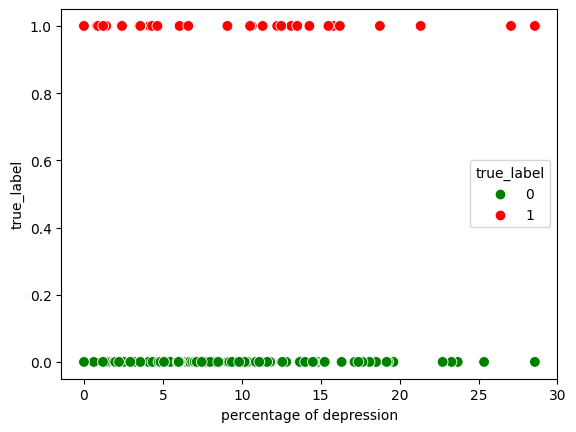

In [47]:
import seaborn as sns

sns.scatterplot(x='percentage of depression',y='true_label',data=df_pred,s=60,hue='true_label',palette=['green','red'])

In [48]:
dp=[]
for i in range (0,len(out_per)):
    if out_per[i]>9:
        dp.append(out_per[i])

In [49]:
len(dp) #includes true negative + false negative

75

In [50]:
df_pred.sort_values(by=['label'])

,person_id,count of depression,percentage of depression,label,true_label
0,"[302_P_0.wav, 302_P_1.wav, 302_P_10.wav, 302_P...",2,4.545455,0,0
77,"[403_P_0.wav, 403_P_1.wav, 403_P_10.wav, 403_P...",2,2.020202,0,0
131,"[477_P_0.wav, 477_P_1.wav, 477_P_10.wav, 477_P...",8,4.848485,0,0
75,"[399_P_0.wav, 399_P_1.wav, 399_P_10.wav, 399_P...",4,5.479452,0,0
132,"[478_P_0.wav, 478_P_1.wav, 478_P_10.wav, 478_P...",1,1.204819,0,0
...,...,...,...,...,...
69,"[390_P_0.wav, 390_P_1.wav, 390_P_10.wav, 390_P...",20,17.699115,1,0
68,"[389_P_0.wav, 389_P_1.wav, 389_P_10.wav, 389_P...",6,14.285714,1,1
64,"[384_P_0.wav, 384_P_1.wav, 384_P_10.wav, 384_P...",13,13.131313,1,1
57,"[375_P_0.wav, 375_P_1.wav, 375_P_10.wav, 375_P...",6,17.142857,1,0


In [51]:
##################################################################

In [52]:
SVM_model = SVC(kernel='rbf',C=10, gamma=1, class_weight='balanced')

SVM_model.fit(X,Y)

SVC(C=10, class_weight='balanced', gamma=1)

In [53]:
true_per=[]
out_per=[]
true_output=[]
pred_output=[]

for i in range (0,len(result)):
    test=df_test[df_test['subject'].isin(result[i])] 
    X_test=test[test.columns.intersection(feature_list)]
    X_test=n.normalize_test(X_test)
    Y_test=test['Group']

    Y_predict_SVM=SVM_model.predict(X_test)
    
    per_pred=np.sum(Y_predict_SVM==1)/Y_predict_SVM.shape[0]*100
    if per_pred>6:
        y_=1
    else:
        y_=0
    
    y=mode(Y_test)
    per=np.sum(Y_test==1)/Y_test.shape[0]*100

    true_per.append(per)
    out_per.append(per_pred)
    true_output.append(y)
    pred_output.append(y_)

print(classification_report(true_output,pred_output))
print(metrics.accuracy_score(true_output,pred_output))
    
    

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       126
           1       0.21      0.14      0.16        37

    accuracy                           0.69       163
   macro avg       0.49      0.49      0.49       163
weighted avg       0.64      0.69      0.66       163

0.6871165644171779


In [54]:
df_pred_SVM=pd.DataFrame({'percentage of depression':true_per,'label':pred_output,'true_label':true_output})

<AxesSubplot: xlabel='percentage of depression', ylabel='true_label'>

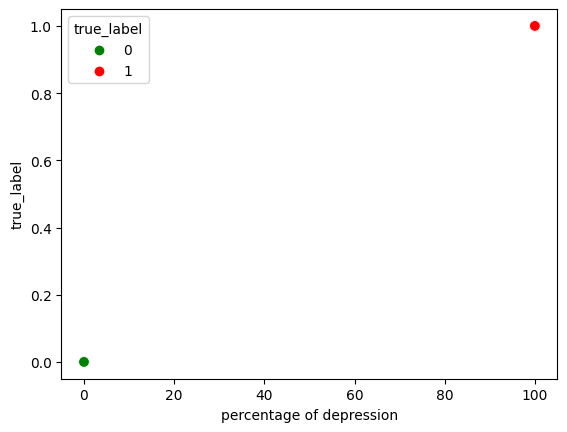

In [55]:
import seaborn as sns

sns.scatterplot(x='percentage of depression',y='true_label',data=df_pred_SVM,s=60,hue='true_label',palette=['green','red'])

#### 1.2 Obtaining a Classification Report:

In [56]:
#from sklearn.metrics import classification_report

In [57]:
#print(classification_report(Y_test,Y_predict_RF))

#### 2. Decision Tree Classifier:

In [58]:
#DF_model=DecisionTreeClassifier(max_depth=7,random_state=42,class_weight='balanced')

In [59]:
#DF_model.fit(X,Y)

#### 2.1 Predicting the output on test data:

In [60]:
#predicting on test data:
#Y_predict_DF=DF_model.predict(X_test)

In [61]:
#viewing accuracy score:
#print("The DF_model accuracy is given as : ",metrics.accuracy_score(Y_test,Y_predict_DF))

#### 2.2 Obtaining a Classification Report:

In [62]:
#print(classification_report(Y_test,Y_predict_DF))

#### 3. Logistic Regression Model:

In [63]:
#LR_model=LogisticRegression(class_weight='balanced')

In [64]:
#LR_model.fit(X,Y)

#### 3.1 Predicting the output on test data:

In [65]:
#predicting on test data:
#Y_predict_LR=LR_model.predict(X_test)

#### 3.2 Obtaining a Classification Report:

In [66]:
#viewing accuracy score:
#print("The LR_model accuracy is given as : ",metrics.accuracy_score(Y_test,Y_predict_LR))

In [67]:
#print(classification_report(Y_test,Y_predict_LR))

#### 4. Support Vector Machine Model:

In [68]:
#SVM_model.fit(X,Y)

#### 4.1 Predicting the output on test data:

In [69]:
#predicting on test data:
#Y_predict_SVM=SVM_model.predict(X_test)

In [70]:
#viewing accuracy score:
#print("The SVM_accuracy is given as : ",metrics.accuracy_score(Y_test,Y_predict_SVM))

#### 4.2 Obtaining a Classification Report:

In [71]:
#print(classification_report(Y_test,Y_predict_SVM))

<font color=red>**C=10 & gamma=1 with resampled gives the best results**</font>

### Feature Combination:

#### PCA (on selected features):

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca=PCA(n_components=10)

In [126]:
x_trainpca=pca.fit_transform(X)
x_testpca=pca.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


ValueError: X has 18 features, but PCA is expecting 20 features as input.

In [75]:
##convert principal components for each sample from numpy array to df:
pca_df=pd.DataFrame(x_trainpca,columns=["PCA1","PCA2","PCA3","PCA4","PCA5","PCA6","PCA7","PCA8","PCA9","PCA10"])
#pca_df["y"]=Y
pca_df.tail()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
7751,0.386461,-1.196920,-0.367822,-1.128620,0.530811,0.316912,-0.597617,0.423301,-0.997922,0.300466
7752,1.390539,1.499144,-1.539370,0.552440,1.244027,0.491231,-0.003076,-0.712125,0.337715,-0.466356
7753,-0.051424,-0.844637,-0.422334,-2.244356,1.017326,-0.620569,2.867247,0.375104,2.905656,0.281815
7754,1.909776,-0.977862,-1.166471,1.301416,0.401972,-0.201328,0.517248,-0.037203,0.101933,-0.162381
7755,0.534708,1.554023,-1.118510,-1.242974,0.107530,0.171300,0.859184,0.046079,-0.305126,-0.038370


In [76]:
#evr provides the amount of info or variance each principal component holds after projecting the data to a lower dimensional space:
print("evr is {}".format(pca.explained_variance_ratio_))

evr is [0.26107036 0.10719508 0.09237315 0.07841294 0.07228046 0.06359017
 0.05304176 0.04933992 0.04820913 0.03761129]


__inference__: 
* principal component 1 holds 52.9%
* principal component 2 holds 24.3%
* principal component 3 holds 9.91%
* principal component 4 holds 5.33% 

adding them all up we get over 92.4%(>90). Hence  we decide to take 4 components.

In [77]:
class classification_models:
#Random Forest Classifier:
    def RF_model(self,X,Y,X1,Y1):
        self.X=X
        self.Y=Y
        self.X1=X1
        self.Y1=Y1
        RF_model=RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=4222)
        RF_model.fit(X,Y)
        Y_predict_RF=RF_model.predict(X1)
        acc= metrics.accuracy_score(Y1,Y_predict_RF)
        
        tn,fp,fn,tp=confusion_matrix(Y1,Y_predict_RF).ravel()
        P=tp/(tp+fp)
        R=tp/(tp+fn)
    #if acc>0.68:
        return acc,P,R

In [78]:
import itertools
flist=[]
for l in range(len(feature_list)):
    for subset in itertools.combinations(feature_list, l):
        flist.append(subset)

In [79]:
len(flist)

1048575

In [80]:
obj=classification_models()
a,p,r=obj.RF_model(X,Y,X_test,Y_test)

/tmp/ipykernel_32689/3261837632.py:15: RuntimeWarning: invalid value encountered in long_scalars
  R=tp/(tp+fn)


In [81]:
print(a,p,r)

0.9180327868852459 0.0 nan


In [82]:
i=0
score=[]
result=[]

for i in range(86000,len(flist)):
        
    
    Xf_train_resampled=df_train_upsampled[df_train_upsampled.columns.intersection(flist[i])]
    Xf=n.normalize_train(Xf_train_resampled)
    Xf_test=df_test[df_test.columns.intersection(flist[i])]
    Xf_test=n.normalize_test(Xf_test)
    obj=classification_models()
    a,p,r=obj.RF_model(Xf,Y,Xf_test,Y_test)
    print(i)
    if a>0.70:
        res=[a,p,r]
        score=[str((flist[i])),a,p,r]
    #if res is not None:
        print(i,flist[i])
        print(res)
        
        result.append(score)
            

ValueError: Found input variables with inconsistent numbers of samples: [61, 16619]

In [ ]:
res_df_pr=pd.DataFrame(result,columns=['Feature','Accuracy','Precision','Recall'])

In [ ]:
res_df_pr

In [ ]:
res_df_pr.to_csv("feature scores for prosody.csv",index=True)

In [ ]:
df_train_upsampled.head()

In [83]:
from sklearn.decomposition import PCA

In [84]:
pca=PCA(n_components=5)

In [115]:
np.std(prosody_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


F0avg     30.692413
F0std     12.374244
F0max     14.753585
F0min      4.799717
F0skew     1.414242
            ...    
PU         1.512539
UVU        0.028538
VVU        0.028538
VP         0.114260
UP         0.029641
Length: 100, dtype: float64

In [116]:
prosody_test=prosody_test.fillna(0)

In [127]:
X_test=df_test[df_test.columns.intersection(feature_list)]
df_test.replace({'Group':{"HC":0,"DP":1}},inplace=True)
X_test=n.normalize_test(X_test)
Y_test=prosody_test['Group']

In [122]:
df_test

,subject,F0avg,F0std,F0max,F0min,F0skew,F0kurt,F0tiltavg,F0mseavg,F0tiltstd,...,kurtosisdurpause,maxdurpause,mindurpause,PVU,PU,UVU,VVU,VP,UP,Group
0,302_P_0.wav,205.149139,83.769669,327.514770,84.000198,-0.168400,-1.775526,-124.519433,56.990329,313.762164,...,-1.595486,0.420000,0.240000,1.406408,7.372219,0.190771,0.809229,0.575387,0.135644,HC
1,302_P_1.wav,102.336777,12.758840,162.222671,84.562759,1.034953,1.608071,-68.756823,14.322919,134.003465,...,-1.093525,0.860000,0.260000,1.573629,4.208813,0.373889,0.626111,0.397877,0.237597,HC
2,302_P_10.wav,100.019585,8.637549,128.070557,78.891289,0.045826,-0.090325,-52.007956,6.935584,55.938566,...,-1.510324,0.749977,0.160000,1.157104,4.461451,0.259356,0.740644,0.640084,0.224142,HC
3,302_P_11.wav,95.671875,4.877093,115.493309,81.509888,0.144567,0.117584,-52.907011,5.970238,50.751226,...,-2.000000,0.380000,0.180000,0.707048,2.434663,0.290409,0.709591,1.003596,0.410735,HC
4,302_P_12.wav,103.323593,8.141882,138.229950,81.609138,1.031435,2.473339,-52.070606,12.869873,101.815253,...,-0.649662,0.530023,0.160000,0.980418,3.166818,0.309591,0.690409,0.704198,0.315774,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16614,707_P_6.wav,121.001251,52.669563,289.174377,65.895073,1.539568,1.082657,-65.027590,35.786118,201.842477,...,0.888730,0.809977,0.160000,0.978466,3.517817,0.278146,0.721854,0.737741,0.284267,HC
16615,707_P_60.wav,111.344917,45.712727,315.101868,75.407440,2.563784,6.238548,-51.918041,16.827485,66.173118,...,-1.500000,0.760000,0.230023,1.177477,5.028434,0.234164,0.765836,0.650405,0.198869,HC
16616,707_P_7.wav,134.930908,47.299625,290.065918,67.527214,1.308148,2.176564,-51.433785,23.661990,166.798960,...,-0.999846,0.460000,0.260000,0.845198,3.437707,0.245861,0.754139,0.892264,0.290892,HC
16617,707_P_8.wav,148.030609,67.229515,341.262604,78.143013,1.541197,1.110275,1.293095,227.568557,267.353188,...,-1.745858,0.390023,0.169977,0.708177,4.088546,0.173210,0.826790,1.167490,0.244586,HC


In [128]:
x_trainpca=pca.fit_transform(X)
x_testpca=pca.transform(X_test)

In [112]:
##convert principal components for each sample from numpy array to df:
pca_df=pd.DataFrame(x_trainpca,columns=["PCA1","PCA2","PCA3","PCA4","PCA5"])
#pca_df['subject','class']=[df_train['subject'],Y]
pca_df['class']=Y
pca_df['subject']=df_train['subject']
pca_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,class,subject
0,-0.092288,-0.450451,-0.531531,-0.268304,0.342860,0,300_P_0.wav
1,-6.267186,-0.377066,-1.201778,0.367445,-0.934426,0,300_P_1.wav
2,0.459630,-2.666841,1.688830,-0.656006,1.134425,0,300_P_10.wav
3,0.151109,-0.452128,-0.385028,-1.244176,2.713292,0,300_P_11.wav
4,-0.477250,0.178113,0.312742,-1.446450,1.184172,0,300_P_12.wav


In [ ]:
print("evr is {}".format(pca.explained_variance_ratio_))

In [111]:
pca_df.to_csv('/home/vboxuser/VoiceFiles/prosodytest_pca.csv')